## AlexNet

Alexnet은 ImageNet 영상 데이터베이스를 기반으로 한 화상 인식 대회인 'ILSVRC 2012'에서 우승한 CNN 구조입니다.

AlexNet을 설명하기에 앞서 AlexNet의 세부 블록을 이해하고자 CNN 구조를 다시 살펴봅시다. CNN은 다음 그림과 같이 3차원 구조를 갖는다는 것을 이해해야 합니다.(이미지를 다루기 때문에 기본적으로 3차원 데이터를 다룹니다.) 이미지 크기를 나타내는 너비(width)와 높이(height)뿐만 아니라 깊이(depth)를 갖습니다. 보통 색상이 많은 이미지는 R/G/B 성분 세 개를 갖기때문에 시작이 3이지만, 합성곱을 거치면서 특성 맵이 만들어지고 이것에 따라 중간 영상의 깊이가 달라집니다.

![](../Static/269.jpg)

이것을 이해했다면 AlexNet 구조에 있는 숫자 의미에 대한 이해가 가능합니다. AlexNet은 `합성곱층 총 다섯 개`와 `완전연결층 세 개`로 구성되어 있으며, 맨 마지막 완전연결층은 카테고리 1000개를 분류하기 위해 `소프트맥스 활성화 함수`를 사용하고 있습니다. 전체적으로 보면 GPU 두 개를 기반으로 한 병렬 구조인 점을 제외하면 LeNet-5와 크게 다르지 않습니다.

![](../Static/270.jpg)

AlexNet의 합성곱층에서 사용된 활성화 함수는 `렐루(ReLU)`로, 각 계층의 구조적 세부 사항은 다음 표를 참고하세요.

|계층 유형|특성 맵|크기|커널 크기|스트라이드|활성화 함수|
|---|---|---|---|---|---|
|이미지|1|227x227|-|-|-|
|합성곱층|96|55x55|11x11|4|렐루(ReLU)|
|최대 풀링층|96|27x27|3x3|2|-|
|합성곱층|256|27x27|3x3|2|렐루(ReLU)|
|최대 풀링층|256|13x13|3x3|2|-|
|합성곱층|384|13x13|3x3|1|렐루(ReLU)|
|합성곱층|384|13x13|3x3|1|렐루(ReLU)|
|합성곱층|256|13x13|3x3|1|렐루(ReLU)|
|최대 풀링층|256|6x6|3x3|2|-|
|완전연결층|-|4096|-|-|렐루(ReLU)|
|완전연결층|-|4096|-|-|렐루(ReLU)|
|완전연결층|-|1000|-|-|소프트맥스(softmax|

네트워크에는 학습 가능한 변수가 총 6600만개 있습니다. 네트워크에 대한 입력은 227x227x3 크기의 RGB 이미지이며, 각 클래스(혹은 카테고리)에 해당하는 1000x1 확률 벡터를 출력합니다.

AlexNet의 첫 번째 합성곱층 커널의 크기는 11x11x3이며, 스트라이드를 4로 적용하여 특성 맵을 96개 생성하기 때문에 55x55x96의 출력을 갖습니다. 첫 번째 계층을 거치면서 GPU-1 에서는 주로 컬러와 상관없는 정보를 추출하기 위한 커널이 학습되고, GPU-2에서는 주로 컬러와 관련된 정보를 추출하기 위한 커널이 학습됩니다.

각 GPU의 결과가 다음 그림과 같이 나타납니다.

![](../Static/271.jpg)

이제 파이토치 코드로 AlexNet에 대해 살펴봅시다. 먼저 필요한 라이브러리를 호출합니다. 전반적인 코드는 LeNet과 크게 다르지 않기 때문에 주로 모델을 구성하는 네트워크가 어떻게 차이가 나는지 위주로 살펴보면 좋습니다.

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim

import torch.nn as nn
import torch.nn.functional as F
import os
import time
import cv2
import random

from PIL import Image
from tqdm import tqdm_notebook as tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


데이터셋은 인간과 말을 구분하는 데이터셋을 사용합니다. 이제 준비된 데이터를 이용할 네트워크를 생성해야 합니다. 원래 AlexNet의 마지막 계층에는 뉴런이 1000개있지만 예제에서는 클래스 두 개만 사용합니다.

![](../Static/272.jpg)

In [2]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train' : transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val' : transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
    
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

이미지가 위치한 경로에서 데이터를 가져와 훈련, 검증, 테스트 용도로 분리합니다. 데이터가 위치한 경로에는 horses 와 humans 폴더로 구성되어 있습니다.

In [3]:
horse_directory = './horse_or_human/train/horses/'
human_directory = './horse_or_human/train/humans/'

horse_image_filepath = sorted([os.path.join(horse_directory, f) for f in os.listdir(horse_directory)])
human_image_filepath = sorted([os.path.join(human_directory, f) for f in os.listdir(human_directory)])
images_filepaths = [*horse_image_filepath, *human_image_filepath]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:800]
val_images_filepaths = correct_images_filepaths[800:-10]
test_images_filepaths = correct_images_filepaths[-10:]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

800 217 10


다음은 훈련,검증,테스트에서 사용할 데이터셋의 이미지 수입니다.
800 217 10

우리가 사용하는 노트북의 성능이 좋지 않다고 가정한채 진행하고 있으므로 훈련 데이터셋을 800개로 제한했습니다.

AlexNet은 파라미터를 6000만 개 사용하는 모델입니다. 이때 충분한 데이터가 없으면 과적합이 발생하는 등 테스트 데이터에 대한 성능이 좋지 않습니다. 우리가 사용할 예제에서는 데이터셋을 상당히 제한하여 사용하고 있기 때문에 성능은 좋지 않다는 것을 미리 언급합니다. 성능이 좋은 결과를 원한다면 충분한 데이터셋을 확보하고 테스트를 진행하면 됩니다. 예를 들어 캐글에서 내려받은 모든 이미지를 사용하는 것뿐만 아니라 전처리 부분에서 데이터를 많이 확장(RandomRotation RandomHorizontalFlip 등을 이용)시켜 예제를 진행해야 합니다.

`torch.utils.data.Dataset`을 상속받아 커스텀 데이터셋(custom dataset)을 정의합니다.


`torch.data.Dataset` 클래스를 상속받아 커스텀 데이터셋을 만들어 보겠습니다.

In [4]:
class CustomDataSet(Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list # 이미지 데이터가 위치한 파일 경로
        self.transform = transform # 이미지 데이터 전처리
        self.phase = phase # self.phase는 ImageTransform()에서 정의한 'train'과 'val'을 의미

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx] # 이미지 데이터의 인덱스를 가져오기
        img = Image.open(img_path).convert('RGB')
        img_transformed = self.transform(img, self.phase)

        label = img_path.split('/')[-1].split('.')[0][:5] # 레이블 값 가져오기
        if label == 'horse':
            label = 1
        elif label == 'human':
            label = 0
    
        return img_transformed, label # 전처리가 적용된 이미지와 레이블 반환

전처리에서 필요한 평균(mean), 표준편차(std) 등에 대한 변수 값을 정의합니다.

In [5]:
size = 256 # AlexNet은 깊이가 깊은 네트워크를 사용하므로 이미지 크기가 256이 아니면 풀링층 때문에 크기가 계속 줄어들어 오류가 발생할 수 있습니다.
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

훈련과 검증 용도의 데이터셋을 정의합니다. 앞에서 정의한 `CustomDataset()` 클래스에 훈련,검증,테스트 데이터를 적용하되 전처리도 함께 적용하도록 합니다.

In [6]:
train_dataset = CustomDataSet(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = CustomDataSet(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')
test_dataset = CustomDataSet(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 256, 256])
0


훈련 데이터셋의 크기는 (3, 256, 256)을 보여 줍니다. 이것에 대한 값은 (채널, 너비, 높이)를 의미합니다.

이제 데이터셋을 데이터로더로 전달하여 메모리로 불러올 준비를 합니다.

In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train' : train_dataloader, 'val' : val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)


torch.Size([32, 3, 256, 256])
tensor([0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
        1, 0, 0, 0, 1, 1, 0, 1])


데이터 관련 준비는 완료되었습니다. 이제 AlexNet 모델에 대한 네트워크를 정의합니다. AlexNet 모델을 사용하기 위한 네트워크는 사전 훈련된 네트워크와 유사하게 정의했습니다.
`합성곱(conv2d)` + `활성화함수(ReLU)` + `풀링(maxPool2D)`이 다섯 번 반복된 후 두 개의 완전연결층과 출력층으로 구성된 네트워크입니다.

In [8]:
class AlexNet(nn.Module):
    def __init__(self) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [9]:
model = AlexNet()
model.to(device=device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [10]:
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [11]:
from torchsummary import summary
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25

In [12]:
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):

    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch+1, num_epoch))
        print('-'*20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            epoch_loss = 0.0
            epoch_corrects = 0

            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)

            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloader_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
          time_elapsed // 60, time_elapsed % 60))
    return model


In [13]:
num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)


Epoch 1/10
--------------------


C:\Users\aqs45\AppData\Local\Temp\ipykernel_2804\976846940.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.6930 Acc: 0.5075


  0%|          | 0/7 [00:00<?, ?it/s]

val Loss: 0.6923 Acc: 0.5438
Epoch 2/10
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.6928 Acc: 0.5088


  0%|          | 0/7 [00:00<?, ?it/s]

val Loss: 0.6921 Acc: 0.5438
Epoch 3/10
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.6929 Acc: 0.5100


  0%|          | 0/7 [00:00<?, ?it/s]

val Loss: 0.6919 Acc: 0.5438
Epoch 4/10
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.6926 Acc: 0.5038


  0%|          | 0/7 [00:00<?, ?it/s]

val Loss: 0.6915 Acc: 0.5438
Epoch 5/10
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.6922 Acc: 0.5125


  0%|          | 0/7 [00:00<?, ?it/s]

val Loss: 0.6912 Acc: 0.5438
Epoch 6/10
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.6923 Acc: 0.5062


  0%|          | 0/7 [00:00<?, ?it/s]

val Loss: 0.6906 Acc: 0.5438
Epoch 7/10
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.6920 Acc: 0.5100


  0%|          | 0/7 [00:00<?, ?it/s]

val Loss: 0.6902 Acc: 0.5438
Epoch 8/10
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.6916 Acc: 0.5250


  0%|          | 0/7 [00:00<?, ?it/s]

val Loss: 0.6902 Acc: 0.6129
Epoch 9/10
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.6913 Acc: 0.5875


  0%|          | 0/7 [00:00<?, ?it/s]

val Loss: 0.6898 Acc: 0.6452
Epoch 10/10
--------------------


  0%|          | 0/25 [00:00<?, ?it/s]

train Loss: 0.6909 Acc: 0.5763


  0%|          | 0/7 [00:00<?, ?it/s]

val Loss: 0.6890 Acc: 0.6083
Training complete in 1m 29s


In [18]:
import pandas as pd

id_list = []
pred_list = []
_id = 0
with torch.no_grad():
    for test_path in tqdm(test_images_filepaths):
        img = Image.open(test_path).convert('RGB')
        _id = test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()

        id_list.append(_id)
        pred_list.append(preds[0])

res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})

C:\Users\aqs45\AppData\Local\Temp\ipykernel_2804\2238104237.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths):


  0%|          | 0/10 [00:00<?, ?it/s]

In [19]:
import matplotlib.pyplot as plt

class_ = classes = {0: 'human', 1: 'horse'}


def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        a = random.choice(res['id'].values)
        label = res.loc[res['id'] == a, 'label'].values[0]
        if label > 0.5:
            label = 1
        else:
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()


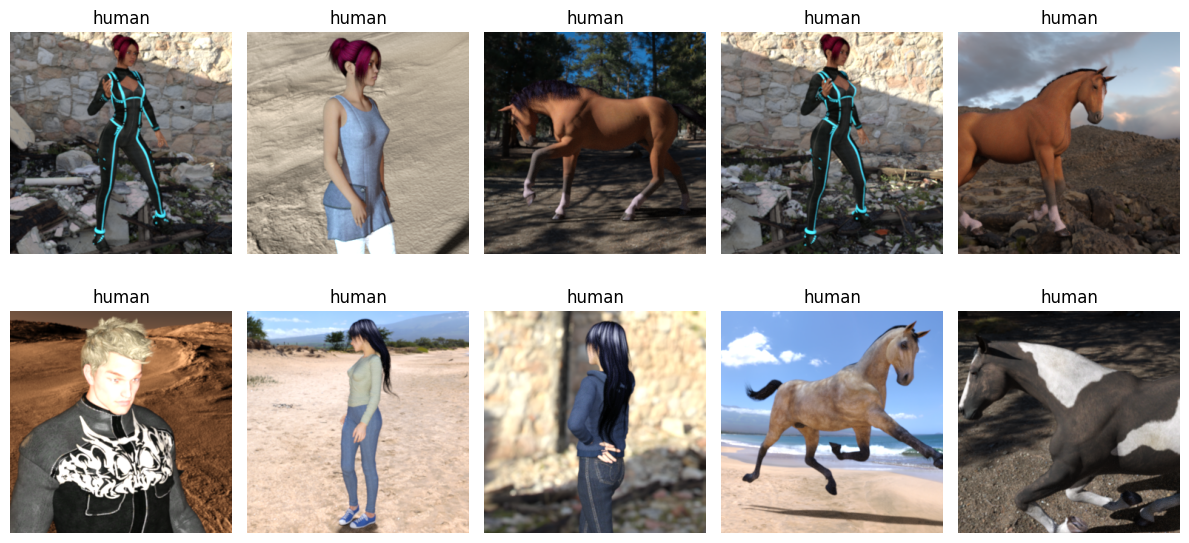

In [20]:
display_image_grid(test_images_filepaths)

예측 결과가 좋지않습니다. 앞에서 언급했지만 데이터셋이 많으면 성능이 좋아질 수 있습니다. 책의 예제들은 실습할 pc의 성능을 고려하여 데이터셋을 제한시켰습니다. 성능은 파라미터 튜닝을 통해서도 향상시킬 수 있습니다. 자세한 내용은 성능 최적화에서 다룹니다.